In [2]:
import ee
import geemap
import xarray as xr
import xee

In [3]:
ee.Authenticate()
ee.Initialize(
    project='ee-aviresearch',
    opt_url='https://earthengine-highvolume.googleapis.com'
)


In [4]:
map = geemap.Map(basemap='SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          81.545849,
                          7.669483
                        ],
                        [
                          81.545849,
                          7.702656
                        ],
                        [
                          81.578808,
                          7.702656
                        ],
                        [
                          81.578808,
                          7.669483
                        ],
                        [
                          81.545849,
                          7.669483
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [8]:
def index(img):
  qa_band = img.select('Fmask')
  cirrus = qa_band.bitwiseAnd(1<<0).neq(0)
  cloud =qa_band.bitwiseAnd(1<<1).neq(0)
  shadow = qa_band.bitwiseAnd(1<<3).neq(0)
  mask = cirrus.Or(cloud).Or(shadow)
  ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
  return ndvi.updateMask(mask.Not()).copyProperties(img,['system:time_start'])

In [42]:
collection =  (
    ee.ImageCollection("NASA/HLS/HLSS30/v002")
    .filterDate('2024','2025')
    .filterBounds(roi)
    .map(index)
)

collection

In [43]:
ds = xr.open_dataset(
    collection,
    engine='ee',
    crs ='EPSG:4326',
    scale =0.0003,
    geometry=roi
)

In [44]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 66, lon: 110, lat: 111)
Coordinates:
  * time     (time) datetime64[ns] 528B 2024-01-07T05:05:59 ... 2024-12-27T05...
  * lon      (lon) float64 880B 81.55 81.55 81.55 81.55 ... 81.58 81.58 81.58
  * lat      (lat) float64 888B 7.67 7.67 7.67 7.671 ... 7.702 7.702 7.702 7.703
Data variables:
    NDVI     (time, lon, lat) float32 3MB ...
Attributes:
    crs:      EPSG:4326

In [45]:
ds = ds.sortby('time')

In [46]:
ds_roi = ds.rolling(time=10,center=True,min_periods=1).mean('time')

In [47]:
ds_10days = ds_roi.resample(time='10D').mean('time')

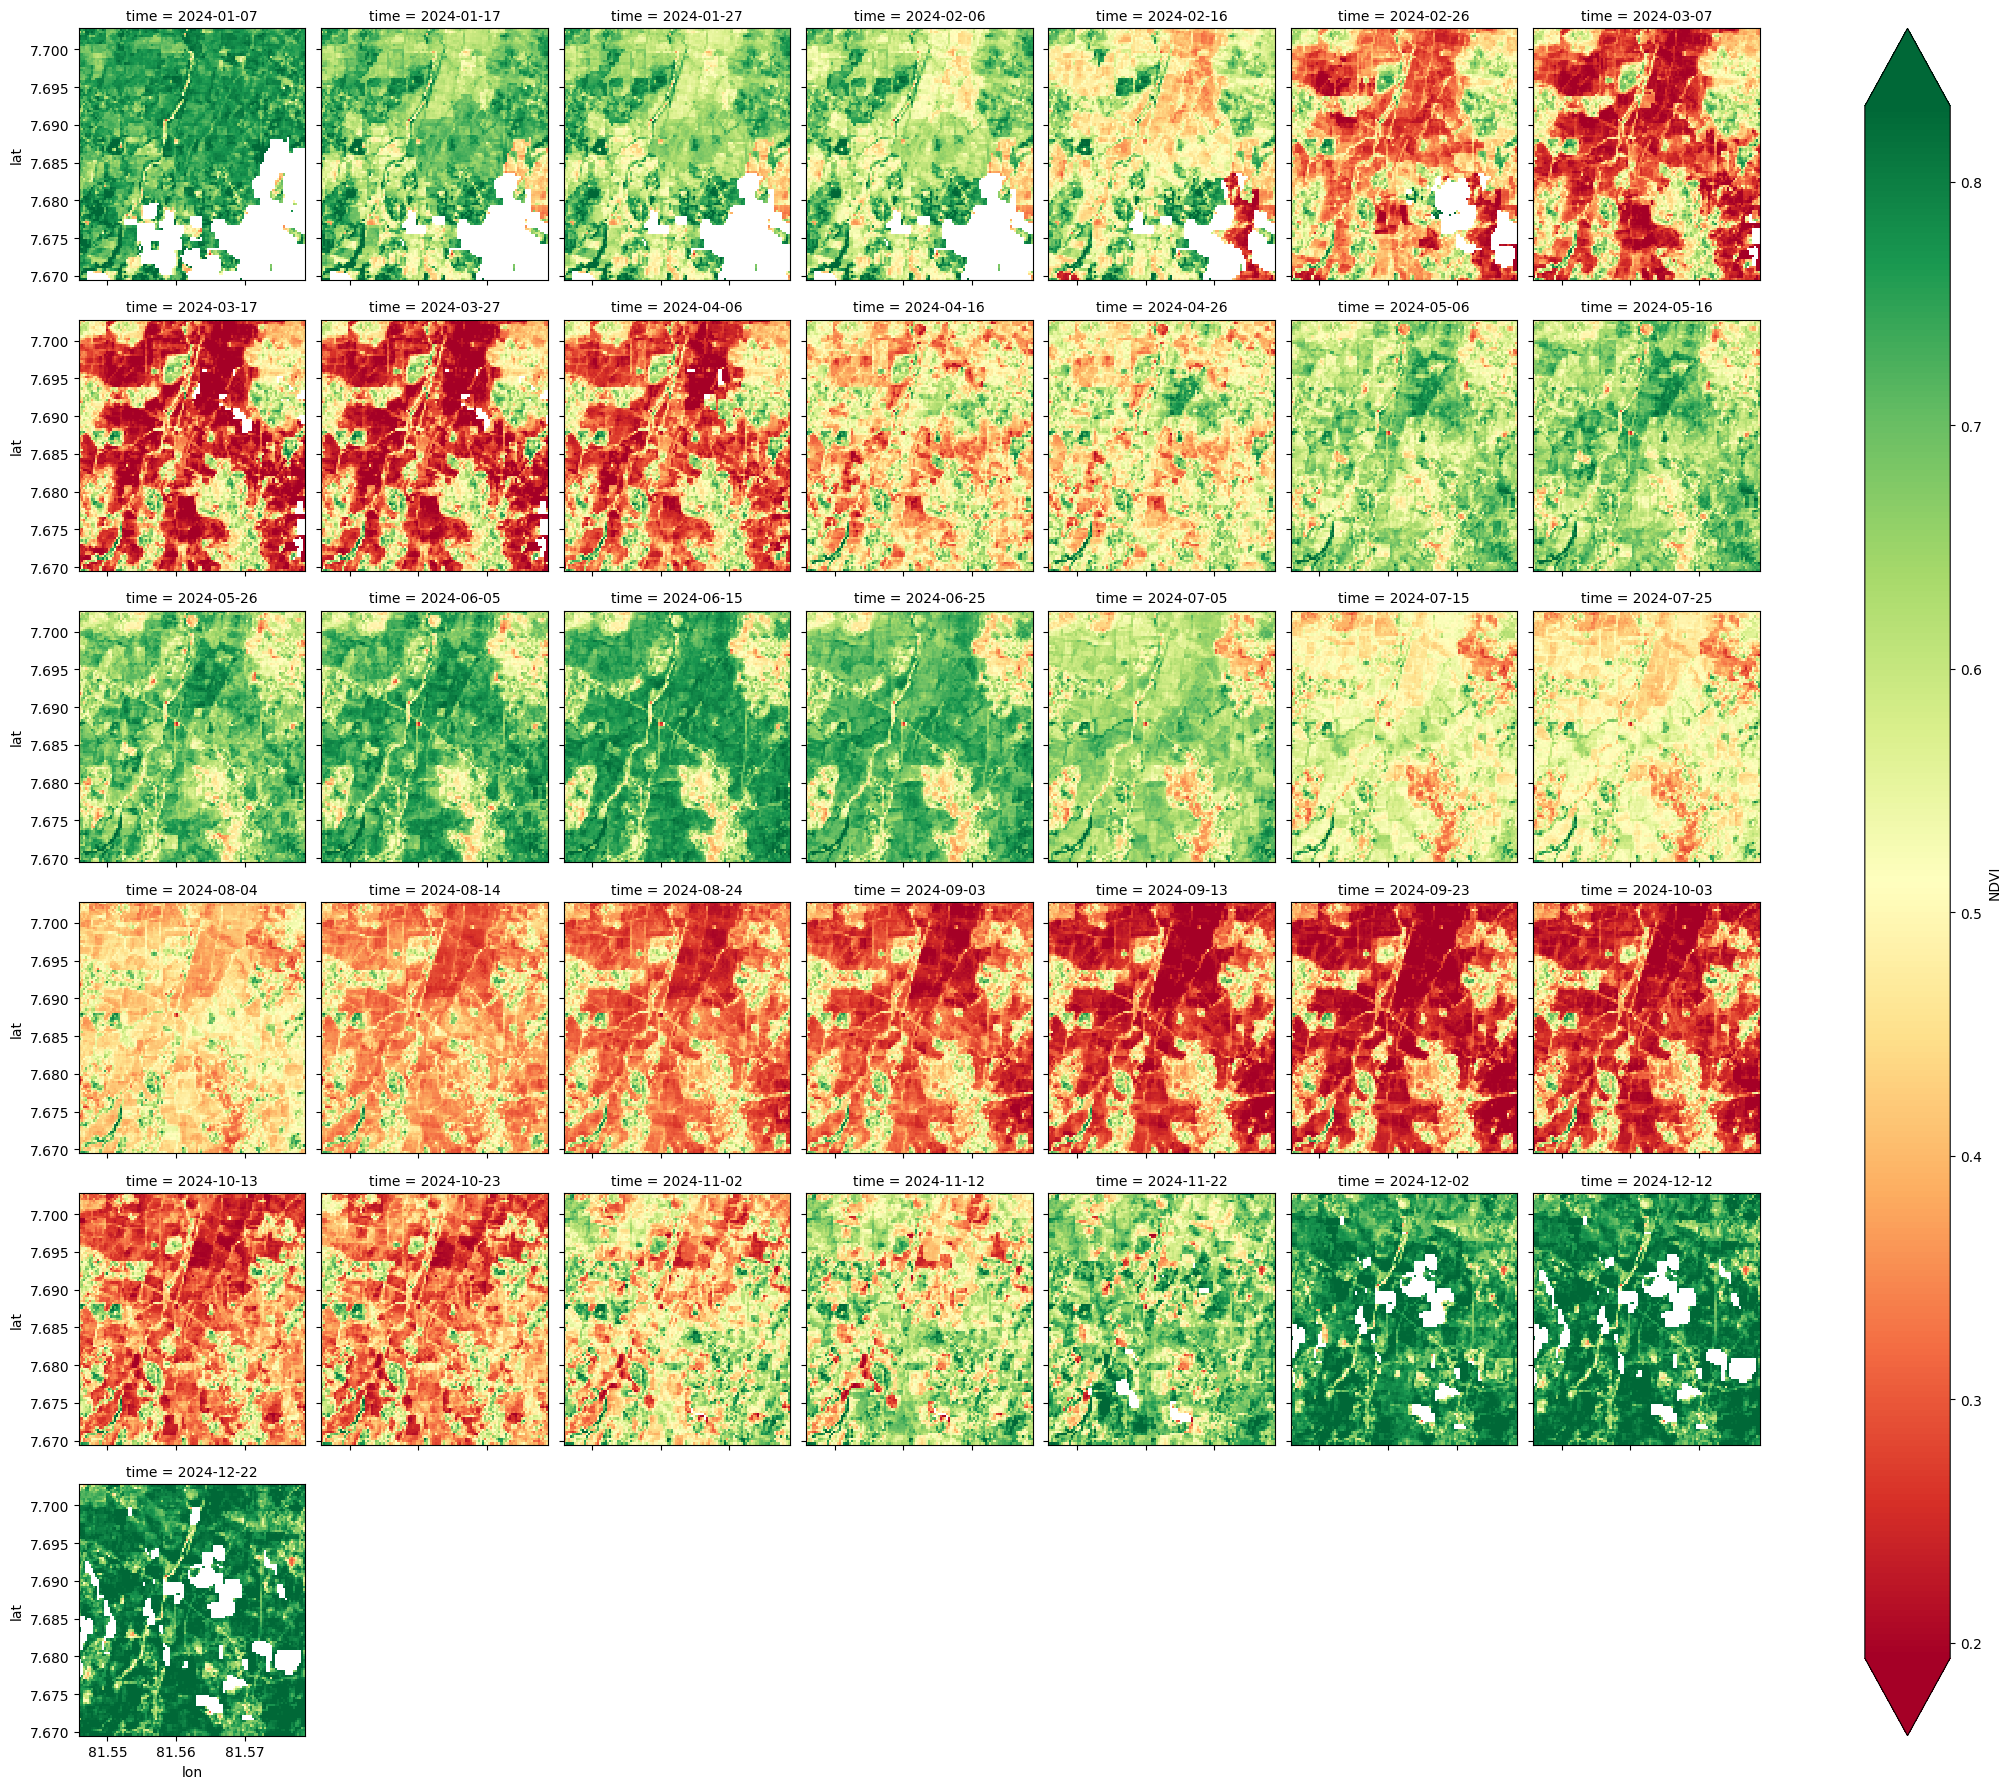

In [48]:
ds_10days.NDVI.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 7,
    cmap = 'RdYlGn',
    robust = True
)

In [56]:
ndvi_peak = ds_10days.max('time')
ndvi_base = ds_10days.min('time')
ndvi_amplitude = ndvi_peak-ndvi_base
ndvi_thr = 0.2*ndvi_amplitude + ndvi_base
ndvi_above = (ds_10days > ndvi_thr).astype(int)
sos = ndvi_above.NDVI.idxmax('time').dt.dayofyear
eos = ndvi_above.NDVI.isel(time = slice(None, None, -1)).idxmax('time').dt.dayofyear
los = eos - sos
los = xr.where(los < 0, los + 365, los)


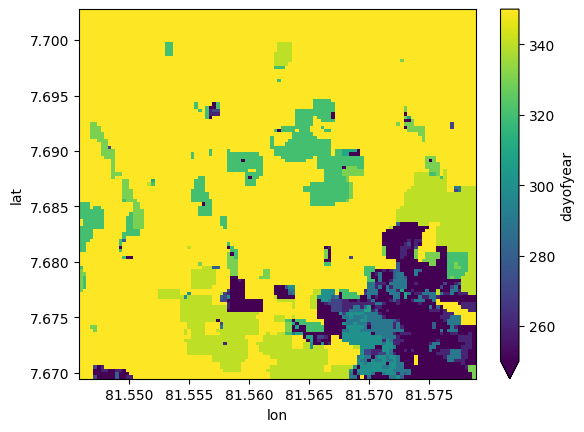

In [57]:

los.plot(
    x = 'lon',
    y = 'lat',
    robust = True
)

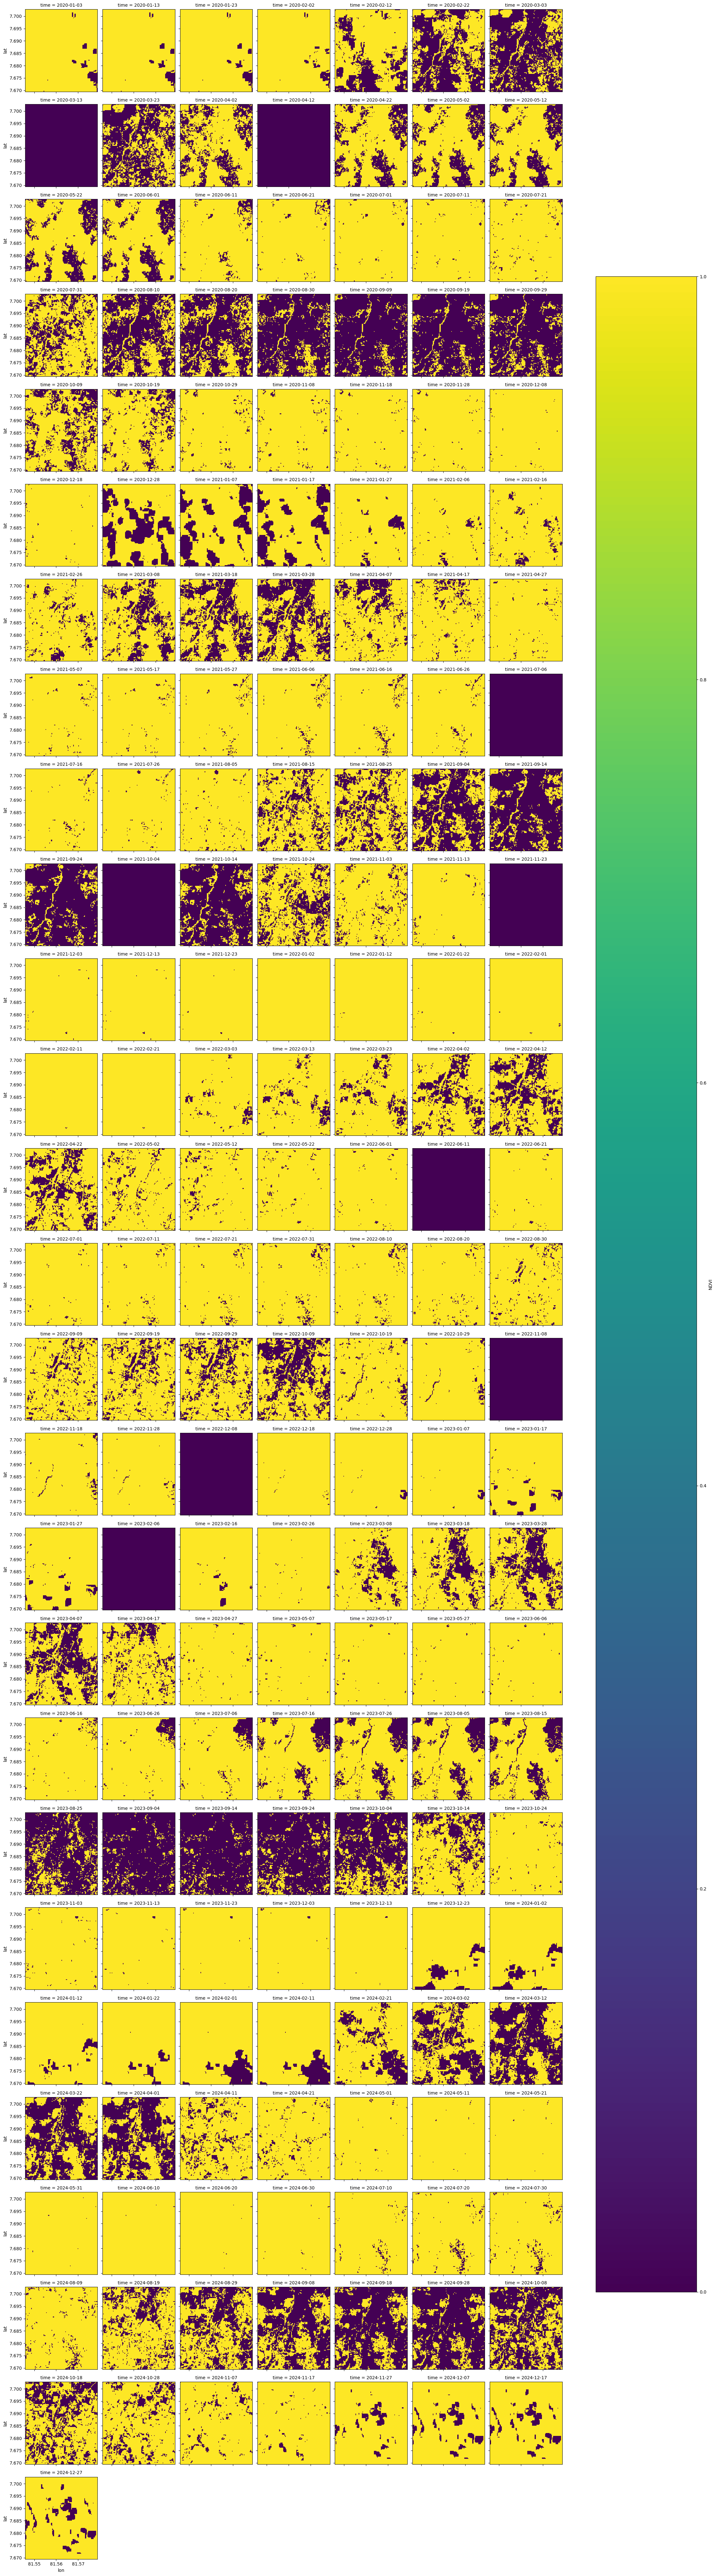

In [37]:
ndvi_above.NDVI.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 7
)